In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.layers import LeakyReLU
import itertools
import warnings
warnings.filterwarnings("ignore")

2024-06-12 19:43:23.161054: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 19:43:23.161183: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 19:43:23.303873: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_34/1652331245.py:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
# Load images
def load_images(base_path):
    data = []
    masked_data = []
    labels = []
    categories = ['COVID-19', 'Non-COVID', 'Normal']

    for category in categories:
        images_path = os.path.join(base_path, category, 'images')
        masks_path = os.path.join(base_path, category, 'lung masks')

        for filename in os.listdir(images_path):
            img_path = os.path.join(images_path, filename)
            mask_path = os.path.join(masks_path, filename)

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            img_masked = cv2.bitwise_and(img, img, mask=mask)
            
            # Apply crop to reduce borders by about 10%
            crop_percent = 10
            h, w = img_masked.shape
            crop_h = int(h * crop_percent / 100)
            crop_w = int(w * crop_percent / 100)
            img_masked_cropped = img_masked[crop_h:h-crop_h, crop_w:w-crop_w]

            data.append(img)
            masked_data.append(img_masked_cropped)  # Use cropped image
            labels.append(category)

    return data, masked_data, labels

data, masked_data, labels = load_images('/kaggle/input/images/Val')
# Load images
def load_images(base_path):
    data = []
    masked_data = []
    labels = []
    categories = ['COVID-19', 'Non-COVID', 'Normal']

    for category in categories:
        images_path = os.path.join(base_path, category, 'images')
        masks_path = os.path.join(base_path, category, 'lung masks')

        for filename in os.listdir(images_path):
            img_path = os.path.join(images_path, filename)
            mask_path = os.path.join(masks_path, filename)

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            img_masked = cv2.bitwise_and(img, img, mask=mask)
            
            # Apply crop to reduce borders by about 10%
            crop_percent = 10
            h, w = img_masked.shape
            crop_h = int(h * crop_percent / 100)
            crop_w = int(w * crop_percent / 100)
            img_masked_cropped = img_masked[crop_h:h-crop_h, crop_w:w-crop_w]

            data.append(img)
            masked_data.append(img_masked_cropped)  # Use cropped image
            labels.append(category)

    return data, masked_data, labels

data, masked_data, labels = load_images('/kaggle/input/images/Val')

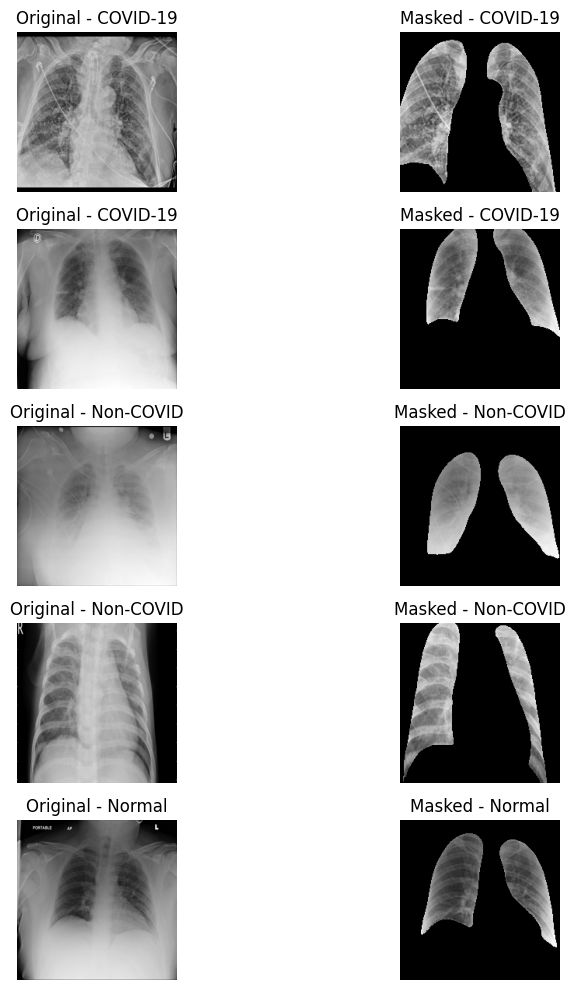

In [3]:
# Visualize images
num_images = 5
plt.figure(figsize=(10, 2 * num_images))
for i in range(num_images):
    plt.subplot(num_images, 2, 2*i + 1)
    plt.imshow(data[i*1000], cmap='gray')
    plt.title(f"Original - {labels[i*1000]}")
    plt.axis('off')

    plt.subplot(num_images, 2, 2*i + 2)
    plt.imshow(masked_data[i*1000], cmap='gray')
    plt.title(f"Masked - {labels[i*1000]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [4]:
# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)
y_categorical = to_categorical(y_encoded)

# Split data into training and testing sets
X = np.array(data).reshape(-1, 256, 256, 1)
y = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.25, random_state=42)

In [5]:
# Define the hypermodel for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(256, 256, 1)))

    for i in range(2, 3):
        units = hp.Int(f'layer_{i}_units', min_value=256, max_value=1024, step=128)
        alpha = hp.Choice(f'alpha_{i}', values=[0.1, 0.2, 0.3, 0.4])
        model.add(Dense(units))
        model.add(LeakyReLU(alpha=alpha))
        model.add(Dropout(0.5))

    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [6]:
from imblearn.under_sampling import RandomUnderSampler

# Apply Random Undersampling to balance the dataset
undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = undersample.fit_resample(X_train.reshape(-1, 256*256), np.argmax(y_train, axis=1))

# Reshape back to original shape
X_resampled = X_resampled.reshape(-1, 256, 256, 1)
y_resampled = to_categorical(y_resampled)

# Define the hypermodel for Keras Tuner with undersampled data
def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(256, 256, 1)))

    for i in range(2, 3):
        units = hp.Int(f'layer_{i}_units', min_value=256, max_value=1024, step=128)
        alpha = hp.Choice(f'alpha_{i}', values=[0.1, 0.2, 0.3, 0.4])
        model.add(Dense(units))
        model.add(LeakyReLU(alpha=alpha))
        model.add(Dropout(0.5))

    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model




In [7]:
# Instantiate the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    directory='my_dir',
    project_name='dnn_tuning3'
)

# Perform the search with undersampled data
tuner.search(X_resampled, y_resampled, epochs=25, validation_data=(X_test, y_test))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print('Test accuracy (best model):', test_acc)

Trial 20 Complete [00h 00m 37s]
val_accuracy: 0.6907749176025391

Best val_accuracy So Far: 0.7143911719322205
Total elapsed time: 00h 15m 09s
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7349 - loss: 186.2104
Test accuracy (best model): 0.7143911719322205


In [8]:
# Define the hypermodel for Keras Tuner with undersampled data
def build_model2(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(256, 256, 1)))

    for i in range(2, 5):
        units = hp.Int(f'layer_{i}_units', min_value=256, max_value=1024, step=128)
        alpha = hp.Choice(f'alpha_{i}', values=[0.1, 0.12, 0.13, 0.14])
        model.add(Dense(units))
        model.add(LeakyReLU(alpha=alpha))
        model.add(Dropout(0.5))

    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
# Instantiate the tuner
tuner2 = RandomSearch(
    build_model2,
    objective='val_accuracy',
    max_trials=20,
    directory='my_dir',
    project_name='dnn_tuning346'
)

# Perform the search with undersampled data
tuner.search(X_resampled, y_resampled, epochs=25, validation_data=(X_test, y_test))

# Get the best model
best_model2 = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print('Test accuracy (best model):', test_acc)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7349 - loss: 186.2104
Test accuracy (best model): 0.7143911719322205


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


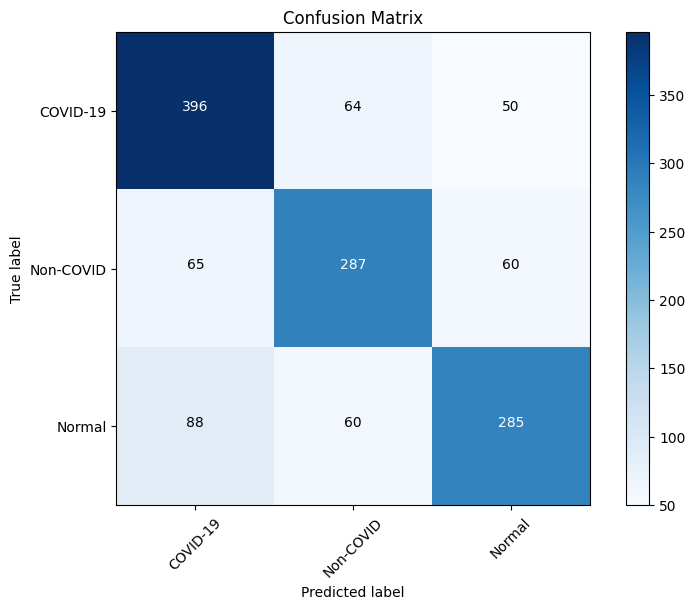

In [9]:
# Plot confusion matrix
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = label_encoder.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

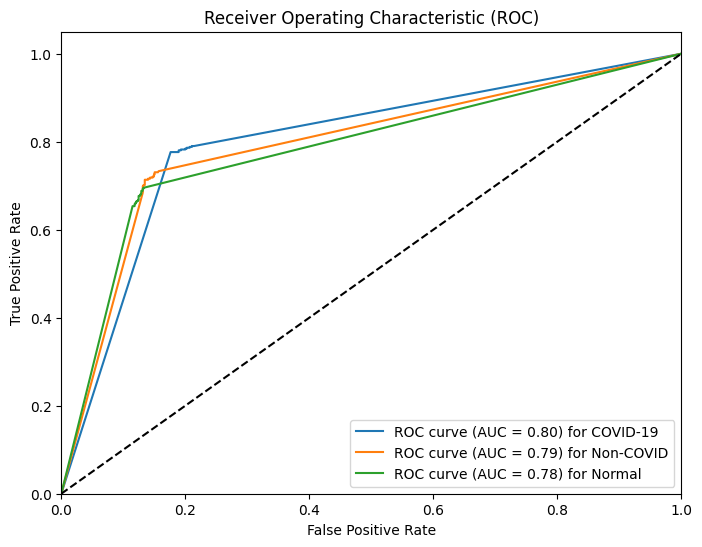

In [10]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 5. Plot ROC curve and calculate AUC
plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (AUC = {roc_auc[i]:.2f}) for {classes[i]}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [11]:
# Save the best model in SavedModel format
best_model.save('best_model_saved_model.h5')